<img src="https://raw.githubusercontent.com/imedinam50/MCDI/main/MCDI.jpg">

<div style="text-align: right"> <H1> Proyecto final MCDI </H1></div>
<br><br><br>
<div style="text-align: right"> <H2> Asesor. Dr. Elio Atenógenes Villaseñor García </H2></div>
<br><br>

<H2>Ingeniería de datos</H2>
<br><br>
<H4><I> 
    Ismael Medina Muñoz
</I></H4>
<br>
<div style="text-align: right"> Fecha de entrega: 2022-0*-** </div>

# Introducción
## TODO

# Planteamiento del problema
La creación artística está siendo impactada por la inteligencia artificial. La música no es un campo ajeno a dicho impacto. La creación musical es un proceso que toma tiempo para el compositor. En un contexto de creación de obras artísticas usadas en productos como comerciales de productos, videojuegos, contenido audiovisual en internet, etc. se requiere de la producción acelerada.
Esta actividad de creación musical ha sido atribuida meramente a los humanos, tal cómo lo establece Morán Martinez, M (2009).

    La creación, la ejecución y la apreciación de la música obedecen fundamentalmente a la capacidad humana para descubrir patrones de sonido e identificarlos en ocasiones posteriores. Sin los procesos biológicos de percepción auditiva y sin consenso cultural sobre lo percibido, entre por lo menos algunos oyentes, no pueden existir ni música ni comunicación musical.

Si bien existen ya muchas investigaciones sobre la composición musical automatizada, la creación asistida e interactiva para los compositores es aún un reto para la investigación, tal como menciona Briot, J. (2021).

Para componer música necesitamos entonces de un generador de nuevas notas singulares o acordes basado en secuencias existentes, coherentes, pero principalmente consonantes, que ya sean parte de un corpus de entrenamiento.

En este proyecto se entrenará una red neuronal profunda para que sea un generador de un grupo de nuevas $n$-notas a un mismo tiempo a partir de dos vectores que representen secuencias de $n$-notas que ocurren a un mismo tiempo y cuya aparición en secuencia representaría grupos de $n$-notas que son consonantes. Este generador será un precursor a la asistencia en la composición de piezas de jazz para piano. Se escogió el género del jazz dado que éste representa un reto para los músicos por su complejidad y riqueza lingüística.

# Metodología propuesta y fundamentación
La composición musical consiste de crear secuencias de $n$-notas con $n = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}$ donde el silencio se representa por un conjunto de $0$-notas. Las $n$-notas ejecutadas en una secuencia $S$ deben ser agradables el oído humano, es decir, consonantes. Las partituras permiten registrar la música a través de escribir las $n$-notas colocadas en relación a su posición relativa en una secuencia $S$ dentro de los límites de un compás. Cada conjunto de $n$-notas tienen una duración que se mantienen bajo las reglas y límites propios de los compases.

La música es precursor del lenguaje hablado y por tanto mantiene una similitud con ésta, tal como establece Lozano(2013). Una oración sólo tiene coherencia si las palabras que la forman resultan en un significado para el receptor de la comunicación. Las oraciones forman párrafos y los signos de puntuación permiten agregar pausas y entonaciones que ayudan a que el cerebro del receptor consuma la información que el emisor pretendía.

Se escogió una fuente digital de partituras para modelar la secuencia $S$ de $n$-notas. El corpus provino entonces de __[musescore.com](https://musescore.com/)__. Desde este sitio se descargaron las partituras en formato **MSCZ** pertenecientes al género del jazz y de ahí se propone hacer la extracción de las $n$-notas asociadas al piano, ya que dichas partituras pueden tener más de un instrumento descrito en sus pentagramas.

Mediante la librería `ms3` se abrirán las partituras y de ellas se obtendrán las secuencias de $n$-notas asociadas al piano. Dichas $n$-notas ocurriendo en la misma posición de tiempo del compás se conocerán como rebanadas. Las secuencias de rebanadas de $n$-notas serán usadas para entrenar la red neuronal que predecirá la siguiente rebanada de $n$-notas en la secuencia. Este generador será el antecedente para la composición musical.

Este trabajo es similar al que ya se aplica para predecir la siguiente palabra o el siguiente número dada una secuencia previa y que ha sido modelado usando redes neuronales recurrentes (RNN).

Todos los conjuntos de datos intermedios en el procesamiento serán almacenados en archivos CSV dado el tiempo requerido para iterar el corpus y la capacidad que ofrece de segmentar el trabajo permitiendo retomar desde el paso último ejecutado.

# Implementación de la metodología
## Carga de librerías y las rutas del corpus

In [1]:
from ms3 import Score, Parse
from fractions import Fraction
import ms3
import os
import pandas as pd
import numpy as np
import math
import ast
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
csv_path = '.\\100output'

## Particularidades del corpus de partituras
Mediante la librería `ms3` se pueden abrir archivos de partituras del software libre MuseScore. La documentación de la librería está disponible en __[ms3 - Parsing MuseScore 3](https://johentsch.github.io/ms3/build/html/index.html)__. La herramienta MuseScore es un proyecto de comunidad que se define como una plataforma de creación de partituras y que además cuenta con un repositorio para que los compositores compartan las partituras creadas. Es de esta fuente que se descargaron 636 partituras en formato **MSCZ**. El contenido de los archivos es consumido mediante el objeto `Score` de la librería.

El objeto `Score` describe metadata de la partitura. La partitura se divide en partes (`Parts`). Cada parte describe los pentagramas (`Staves`) asociados a un instrumento (`Instrument`). Con dicha metadata entonces se puede extraer el conjunto de notas y silencios `notes_and_rests` para las partes que describen los pentagramas de un instrumento.

El conjunto de datos `notes_and_rests` es un Pandas DataFrame que describe una partitura a través de las siguientes columnas.

* **Measure Count (mc)**. La característica describe el compás actual donde la nota o el silencio están siendo descritos. Este indica el conteo de los compases aún si estos tuvieran notas en anacrusa. Este es un arreglo base 1.
* **Measure Number (mn)**. La característica describe el número de compás completo donde la nota o el silencio están siendo descritos. Este representa la manera en la que los humanos se refieren a la posición en una partitura. Este es un arreglo base 0.
* **Measure Number On Set (mn_onset)**. La característica describe la distancia de la posición solicitada desde el tiempo 1 del primer compás completo (mn) tomando en cuenta que esto puede estar en anacruza, expresada como fracción de una nota entera. El valor predeterminado es 0, es decir, la posición del tiempo 1.
* **Measure Count On Set (mc_onset)**. La característica describe la distancia de la posición solicitada desde el tiempo 1 del compás completo (mc), expresada como fracción de una nota entera. El valor predeterminado es 0, es decir, la posición del tiempo 1.
* **Time Signature (timesig)**. Tiempo del compás actual y de ahí los subsecuentes.
* **Staff (staff)**. Número del pentagrama en la partitura.
* **Voice (voice)**. Número de la voz del instrumento que ejecuta la partitura.
* **Duration (duration)**. Duración de la nota en cuestión
* **Tied (tied)**. Ligadura, esto indica que la nota está ligada hacia adelante (1) o hacia atrás (-1) con otras notas en la partitura.
* **MIDI (midi)**. Nota MIDI que debe ser ejecutada por la voz en una posición específica, con una duración específica, en un pentagrama específico y que puede tener ligaduras en la partitura.
* **Tonal pitch classes (tpc)**.
* **Chord ID (chord_id)**.

## Análisis Exploratorio de Datos
Para entender las partituras y las propiedades del objeto `Score` se hizo un análisis exploratorio de datos. A continuación se presentan los análisis. Este procesamiento mostrará el análisis para el corpus completo de partituras, lo que extiende el trabajo en la libreta `001-AnalisisExploratorioDeDatosV2.ipynb`.

### TODO
Se necesita tener las distribuciones de probabilidad siguientes

1. Silencios y no silencios. Esta distribución definirá aleatoriedad en la ejecución de $n$-notas por pentagrama
2. Duración de las notas agrupadas por pentagrama, métrica del pentagrama y por cantidad de $n$-notas. Aquí podría aún aplicarse una generalización de tiempos binarios, ternarios y o compuestos, aunque estos últimos deberían caer en tiempo regulares binarios o ternarios (para definir)
3. Duración de los silencios agrupados por pentagrama y por métrica del pentagrama. Aquí podría aún aplicarse una generalización de tiempos binarios, ternarios y o compuestos, aunque estos últimos deberían caer en tiempo regulares binarios o ternarios (para definir)
4. La red neuronal necesita tensores no de 10 notas sino 2 tensores de 5 notas, así podemos agregar independencia de manos y por lo mismo, independencia en los tiempos de cada grupo de $n$-notas para cada mano.

### ¿Realmente se tocan hasta 5 notas por pentagrama en cada rebanada de tiempo?
La ejecución en piano dictaría que cada uno de los 2 pentagramas, uno en clave de Sol y otro en la clave de Fa, sólo podría describir 5 notas diferentes dada la disposición de la mano humana. Esto suma entonces las 10 notas que las manos humanas, en conjunto, podrían tocar.

Es importante identificar si para cada rebanada de tiempo tenemos la pulsación de 10 notas como máximo. Suponemos que cada conjunto de $n$-notas pulsadas en la misma posición relativa en el compás debe ser de 10 elementos cuando más. Comprobarlo serviría para remover estructuras que den información no factible a la red neuronal. El código siguiente permite analizar una partitura cada vez agrupando los dato por `Measure Number` para hacer una lectura similar a la humana considerando la anacrusa.

In [3]:
n_notes_count =  pd.DataFrame(columns=['filename', 'part', 'staff', 'time_signature', 'count_n_notes'])
mc_onset_count = pd.DataFrame(columns=['filename', 'part', 'staff', 'time_signature', 'duration', 'n_note_count'])
mc_onset_rest_count = pd.DataFrame(columns=['filename', 'part', 'staff', 'time_signature', 'duration', 'rest_count'])
n_notes_midi_range = pd.DataFrame(columns=['filename', 'part', 'staff', 'midi'])

part = "part_1"
for filename in os.listdir(csv_path): ##[0:15]:
    try:
        file = csv_path + '\\' + filename
        print(file)

        time_signature = Fraction(1, 1)

        if("__n_notes_2_2_sequence.csv" in filename):
            time_signature = '2/2'
        if("__n_notes_2_4_sequence.csv" in filename):
            time_signature = '2/4'
        if("__n_notes_3_4_sequence.csv" in filename):
            time_signature = '3/4'
        if("__n_notes_4_4_sequence.csv" in filename):
            time_signature = '4/4'
        if("__n_notes_5_4_sequence.csv" in filename):
            time_signature = '5/4'

        n_notes_sequence = pd.read_csv(file, index_col = 0)
        for key, row in n_notes_sequence.iterrows():
            staff_C_notes    = ast.literal_eval(re.sub(r'(?<=\d)(\s+)(?=-?\d)', ',', row.staff01_notes))
            staff_C_duration = max([Fraction(x) for x in ast.literal_eval(re.sub(r'(?<=\d)(\s+)(?=-?\d)', ',', row.staff01_durations))])
            staff_C_n_notes  = np.count_nonzero(staff_C_notes)
            staff_F_notes    = ast.literal_eval(re.sub(r'(?<=\d)(\s+)(?=-?\d)', ',', row.staff02_notes))
            staff_F_duration = max([Fraction(x) for x in ast.literal_eval(re.sub(r'(?<=\d)(\s+)(?=-?\d)', ',', row.staff02_durations))])
            staff_F_n_notes  = np.count_nonzero(staff_F_notes)
            if staff_F_duration > staff_C_duration:
                max_staff_duration = staff_F_duration
            else:
                max_staff_duration = staff_C_duration

            ##print(staff_C_notes, staff_C_duration, staff_C_n_notes)

            n_notes_count.loc[len(n_notes_count.index)] = (filename, part, 1, time_signature, staff_C_n_notes)
            n_notes_count.loc[len(n_notes_count.index)] = (filename, part, 2, time_signature, staff_F_n_notes)
            mc_onset_count.loc[len(mc_onset_count.index)] = (filename, part, 1, time_signature, staff_C_duration, staff_C_n_notes)
            mc_onset_count.loc[len(mc_onset_count.index)] = (filename, part, 2, time_signature, staff_F_duration, staff_F_n_notes)
            if (staff_C_n_notes == 0):
                mc_onset_rest_count.loc[len(mc_onset_rest_count.index)] = (filename, part, 1, time_signature, max_staff_duration, 1)
            else:
                for note in staff_C_notes:
                    if note > 0:
                        n_notes_midi_range.loc[len(n_notes_midi_range.index)] = (filename, part, 1, note)

            if (staff_F_n_notes == 0):
                mc_onset_rest_count.loc[len(mc_onset_rest_count.index)] = (filename, part, 2, time_signature, max_staff_duration, 1)
            else:
                for note in staff_F_notes:
                    if note > 0:
                        n_notes_midi_range.loc[len(n_notes_midi_range.index)] = (filename, part, 2, note)
    except:
        print('!', end = '')
        ##max_midi = 0
        ##n_notes_count = pd.read_csv('.\\data\\n_notes_count.csv', index_col = 0)

.\100output\20231024_12_50_06_770027__n_notes_2_2_sequence.csv
.\100output\20231024_12_50_06_770027__n_notes_2_4_sequence.csv
.\100output\20231024_12_50_06_770027__n_notes_3_4_sequence.csv
.\100output\20231024_12_50_06_770027__n_notes_4_4_sequence.csv
.\100output\20231024_12_50_06_770027__n_notes_5_4_sequence.csv
.\100output\20231024_12_50_20_712300__n_notes_2_2_sequence.csv
.\100output\20231024_12_50_20_712300__n_notes_2_4_sequence.csv
.\100output\20231024_12_50_20_712300__n_notes_3_4_sequence.csv
.\100output\20231024_12_50_20_712300__n_notes_4_4_sequence.csv
.\100output\20231024_12_50_20_712300__n_notes_5_4_sequence.csv
.\100output\20231024_12_50_31_772377__n_notes_2_2_sequence.csv
.\100output\20231024_12_50_31_772377__n_notes_2_4_sequence.csv
.\100output\20231024_12_50_31_772377__n_notes_3_4_sequence.csv
.\100output\20231024_12_50_31_772377__n_notes_4_4_sequence.csv
.\100output\20231024_12_50_31_772377__n_notes_5_4_sequence.csv
.\100output\20231024_12_50_44_001624__n_notes_2_2_seque

.\100output\20231024_12_56_34_772011__n_notes_2_4_sequence.csv
.\100output\20231024_12_56_34_772011__n_notes_3_4_sequence.csv
.\100output\20231024_12_56_34_772011__n_notes_4_4_sequence.csv
.\100output\20231024_12_56_34_772011__n_notes_5_4_sequence.csv
.\100output\20231024_12_56_51_629158__n_notes_2_2_sequence.csv
.\100output\20231024_12_56_51_629158__n_notes_2_4_sequence.csv
.\100output\20231024_12_56_51_629158__n_notes_3_4_sequence.csv
.\100output\20231024_12_56_51_629158__n_notes_4_4_sequence.csv
.\100output\20231024_12_56_51_629158__n_notes_5_4_sequence.csv
.\100output\20231024_12_57_19_816718__n_notes_2_2_sequence.csv
.\100output\20231024_12_57_19_816718__n_notes_2_4_sequence.csv
.\100output\20231024_12_57_19_816718__n_notes_3_4_sequence.csv
.\100output\20231024_12_57_19_816718__n_notes_4_4_sequence.csv
.\100output\20231024_12_57_19_816718__n_notes_5_4_sequence.csv
.\100output\20231024_12_57_47_395583__n_notes_2_2_sequence.csv
.\100output\20231024_12_57_47_395583__n_notes_2_4_seque

.\100output\20231024_13_05_07_367551__n_notes_3_4_sequence.csv
.\100output\20231024_13_05_07_367551__n_notes_4_4_sequence.csv
.\100output\20231024_13_05_07_367551__n_notes_5_4_sequence.csv
.\100output\20231024_13_05_25_863307__n_notes_2_2_sequence.csv
.\100output\20231024_13_05_25_863307__n_notes_2_4_sequence.csv
.\100output\20231024_13_05_25_863307__n_notes_3_4_sequence.csv
.\100output\20231024_13_05_25_863307__n_notes_4_4_sequence.csv
.\100output\20231024_13_05_25_863307__n_notes_5_4_sequence.csv
.\100output\20231024_13_05_41_902182__n_notes_2_2_sequence.csv
.\100output\20231024_13_05_41_902182__n_notes_2_4_sequence.csv
.\100output\20231024_13_05_41_902182__n_notes_3_4_sequence.csv
.\100output\20231024_13_05_41_902182__n_notes_4_4_sequence.csv
.\100output\20231024_13_05_41_902182__n_notes_5_4_sequence.csv
.\100output\20231024_13_05_58_777070__n_notes_2_2_sequence.csv
.\100output\20231024_13_05_58_777070__n_notes_2_4_sequence.csv
.\100output\20231024_13_05_58_777070__n_notes_3_4_seque

.\100output\20231024_13_12_07_292747__n_notes_4_4_sequence.csv
.\100output\20231024_13_12_07_292747__n_notes_5_4_sequence.csv
.\100output\20231024_13_12_21_619680__n_notes_2_2_sequence.csv
.\100output\20231024_13_12_21_619680__n_notes_2_4_sequence.csv
.\100output\20231024_13_12_21_619680__n_notes_3_4_sequence.csv
.\100output\20231024_13_12_21_619680__n_notes_4_4_sequence.csv
.\100output\20231024_13_12_21_619680__n_notes_5_4_sequence.csv
.\100output\20231024_13_12_37_847234__n_notes_2_2_sequence.csv
.\100output\20231024_13_12_37_847234__n_notes_2_4_sequence.csv
.\100output\20231024_13_12_37_847234__n_notes_3_4_sequence.csv
.\100output\20231024_13_12_37_847234__n_notes_4_4_sequence.csv
.\100output\20231024_13_12_37_847234__n_notes_5_4_sequence.csv
.\100output\20231024_13_12_59_398157__n_notes_2_2_sequence.csv
.\100output\20231024_13_12_59_398157__n_notes_2_4_sequence.csv
.\100output\20231024_13_12_59_398157__n_notes_3_4_sequence.csv
.\100output\20231024_13_12_59_398157__n_notes_4_4_seque

In [4]:
n_notes_count.head(10)

,filename,part,staff,time_signature,count_n_notes
0,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
1,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0
2,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
3,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0
4,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
5,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2
6,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
7,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2
8,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
9,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2


In [5]:
n_notes_count.to_csv('.\\comparisondata\\n_notes_count.csv')

In [6]:
n_notes_count = pd.read_csv('.\\comparisondata\\n_notes_count.csv', index_col = 0)

In [7]:
n_notes_count.head(10)

,filename,part,staff,time_signature,count_n_notes
0,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
1,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0
2,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
3,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0
4,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
5,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2
6,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
7,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2
8,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,2
9,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,2


In [8]:
mc_onset_count.to_csv('.\\comparisondata\\mc_onset_count.csv')

In [9]:
mc_onset_count = pd.read_csv('.\\comparisondata\\mc_onset_count.csv', index_col = 0)

In [10]:
mc_onset_count

,filename,part,staff,time_signature,duration,n_note_count
0,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,1/4,2
1,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0,0
2,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,3/16,2
3,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,0,0
4,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,1,2/2,1/8,2
...,...,...,...,...,...,...
63995,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,0,0
63996,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,1,5/4,1/2,1
63997,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,0,0
63998,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,1,5/4,3/32,1


In [11]:
mc_onset_rest_count.to_csv('.\\comparisondata\\mc_onset_rest_count.csv')

In [12]:
mc_onset_rest_count = pd.read_csv('.\\comparisondata\\mc_onset_rest_count.csv', index_col = 0)

In [13]:
mc_onset_rest_count

,filename,part,staff,time_signature,duration,rest_count
0,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,1/4,1
1,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,3/16,1
2,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,1/8,1
3,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,1/2,1
4,20231024_12_50_06_770027__n_notes_2_2_sequence...,part_1,2,2/2,1/8,1
...,...,...,...,...,...,...
30955,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,1/16,1
30956,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,1/16,1
30957,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,1/16,1
30958,20231024_13_17_35_923143__n_notes_5_4_sequence...,part_1,2,5/4,1/2,1


In [14]:
n_notes_midi_range.to_csv('.\\comparisondata\\n_notes_midi_range.csv')

In [15]:
n_notes_midi_range = pd.read_csv('.\\comparisondata\\n_notes_midi_range.csv', index_col = 0)

In [16]:
n_notes_midi_range.sort_values(by='midi').head(10)

,filename,part,staff,midi
11610,20231024_12_57_19_816718__n_notes_3_4_sequence...,part_1,2,31
33567,20231024_13_13_32_910538__n_notes_3_4_sequence...,part_1,2,31
33377,20231024_13_13_32_910538__n_notes_2_2_sequence...,part_1,2,31
21710,20231024_13_05_41_902182__n_notes_2_2_sequence...,part_1,2,31
21888,20231024_13_05_41_902182__n_notes_3_4_sequence...,part_1,2,31
29295,20231024_13_10_32_618630__n_notes_5_4_sequence...,part_1,2,31
6506,20231024_12_53_46_783559__n_notes_4_4_sequence...,part_1,2,31
6603,20231024_12_53_46_783559__n_notes_5_4_sequence...,part_1,2,31
21799,20231024_13_05_41_902182__n_notes_2_4_sequence...,part_1,2,31
33757,20231024_13_13_32_910538__n_notes_5_4_sequence...,part_1,2,31


### Gráfica de la cantidad de notas pulsadas en los pentagramas en cada rebanada de tiempo por métrica del compas
Es notoria que la mayoría de $n$-notas se describen como $1$-notas, $2$-notas, $3$-notas y $4$-notas. Existen pocas combinaciones de $5$-notas e incluso hay unas pocas $6$-notas y $7$-notas. El caso de $6$-notas y $7$-notas es interesante dado que esperariamos que no existieran este tipo de pulsaciones. Esta partitura tiene compases definidos con tiempos muy variados. Regularmente en el jazz clásico tendremos el ritmo de vals ($ \frac {3} {4} $), el blues ($ \frac {12} {8} $) y el tiempo de ($ \frac {4} {4} $) donde se pueden representar otros tipos de ritmos.

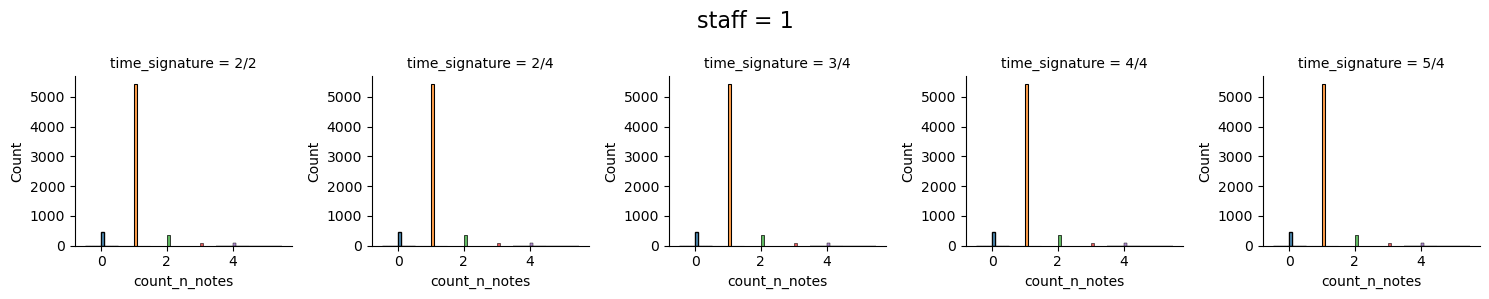

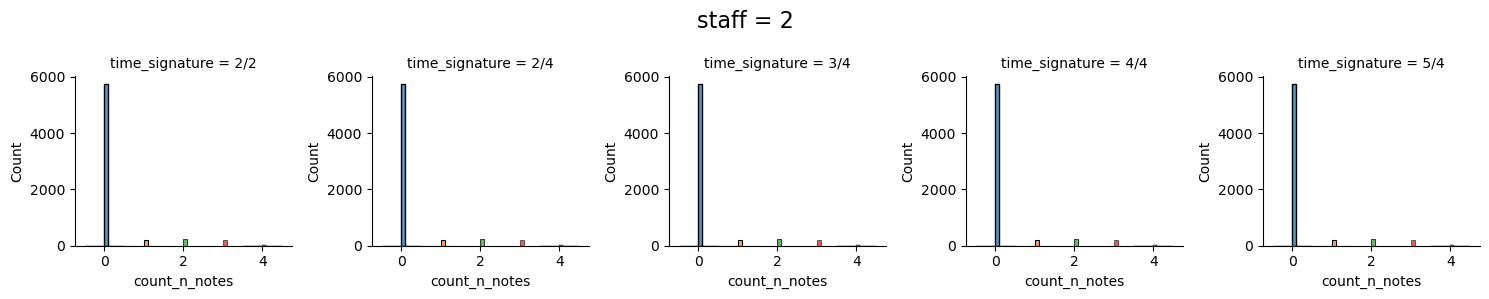

In [17]:
for staff in n_notes_count.staff.unique():
    g = sns.FacetGrid(data=n_notes_count[n_notes_count.staff==staff], col='time_signature', col_wrap=5, 
                      hue = 'count_n_notes', margin_titles=True, sharex= False, sharey= False)

    #add histograms to each plot
    g.map(sns.histplot, 'count_n_notes', bins=10)
    g.fig.suptitle(f"staff = {staff}", size=16)
    ##g.add_legend()
    ##g.fig.subplots_adjust(top = 0.9)
    g.figure.tight_layout()

### Estadísticas de las duraciones de las notas
Para un trabajo posterior a desarrollar, resulta de interés el obtener las duraciones de las notas que conformarán el dataframe de las rebanadas de $n$-notas.

C:\Users\ismedina\AppData\Local\anaconda3\envs\mcdi_2021_3_10\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\ismedina\AppData\Local\anaconda3\envs\mcdi_2021_3_10\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


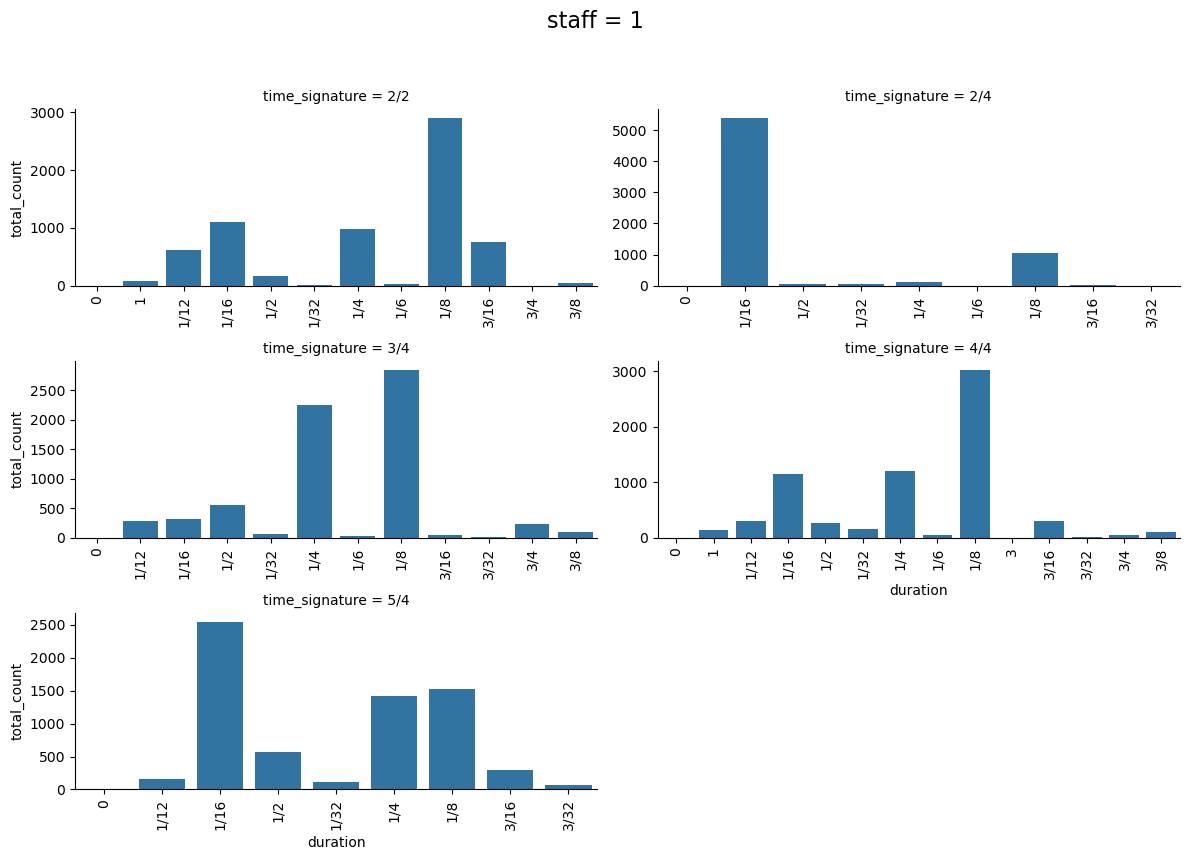

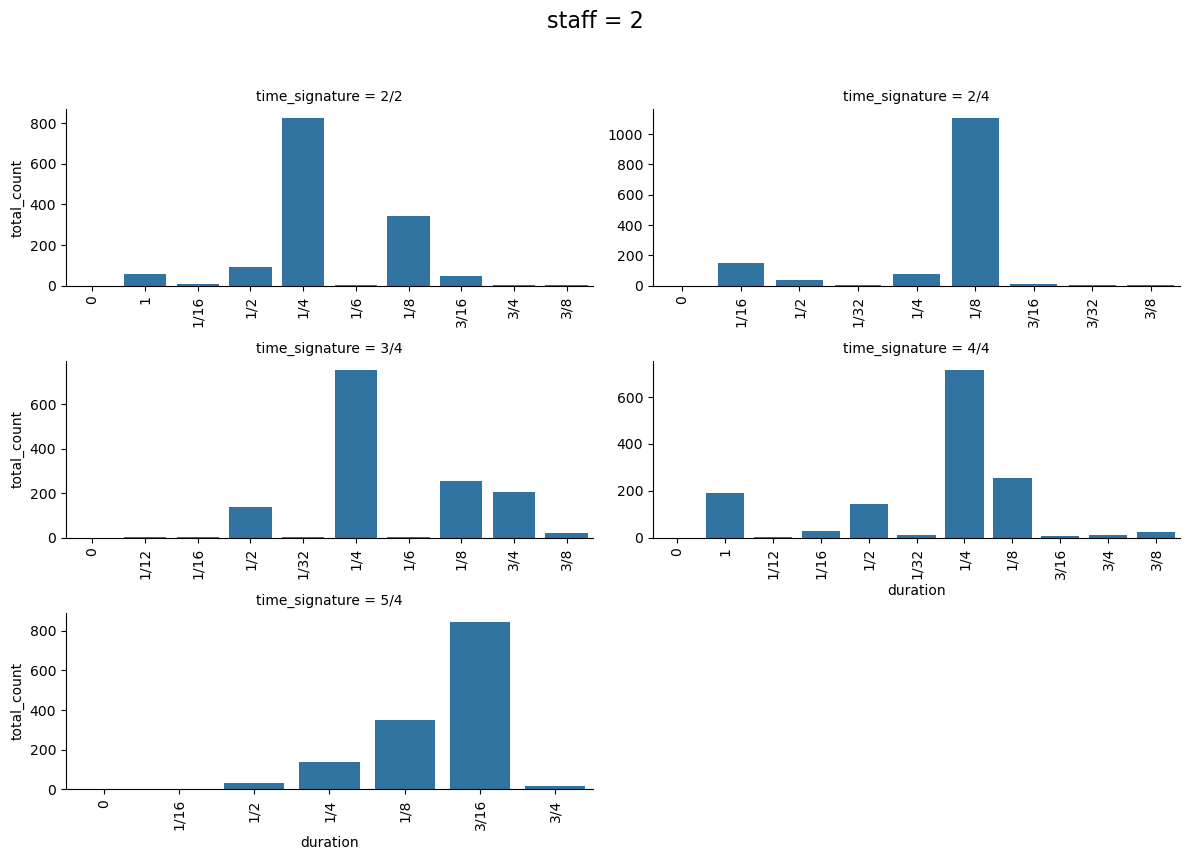

In [18]:
for staff in mc_onset_count.staff.unique():
    g = sns.FacetGrid(data=mc_onset_count[mc_onset_count.staff==staff].groupby(by=['staff', 'time_signature', 'duration'], as_index=False).agg(total_count=('n_note_count', 'sum')), col='time_signature', 
                      col_wrap=2, margin_titles=True, aspect = 2, sharex= False, sharey= False)

    #add histograms to each plot

    g.map(sns.barplot, 'duration', 'total_count')
    
    g.set_xticklabels(rotation=90)
    g.figure.subplots_adjust(top = 0.9)
    g.figure.suptitle(f"staff = {staff}", size = 16)

    g.figure.tight_layout(rect=[0, 0.03, 1, 0.95])    

Se puede concluir hasta aquí que los tiempos binarios son predominantes mientras que hay unos pocos ternarios y que las duraciones bajas no son comunes.

### Estadísticas de las duraciones de los silencios
Para un trabajo posterior a desarrollar, resulta de interés el obtener las duraciones de los silencios existentes en las rebanadas de $n$-notas.

C:\Users\ismedina\AppData\Local\anaconda3\envs\mcdi_2021_3_10\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\ismedina\AppData\Local\anaconda3\envs\mcdi_2021_3_10\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


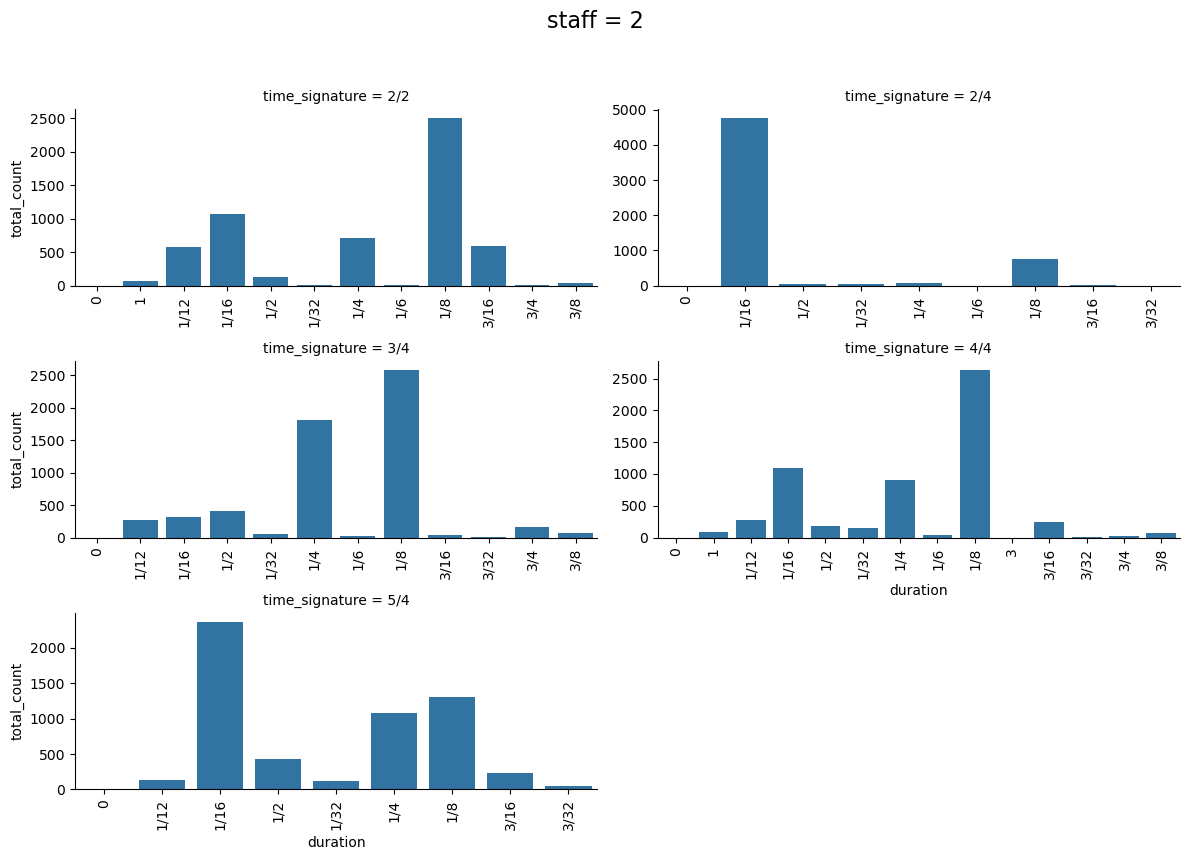

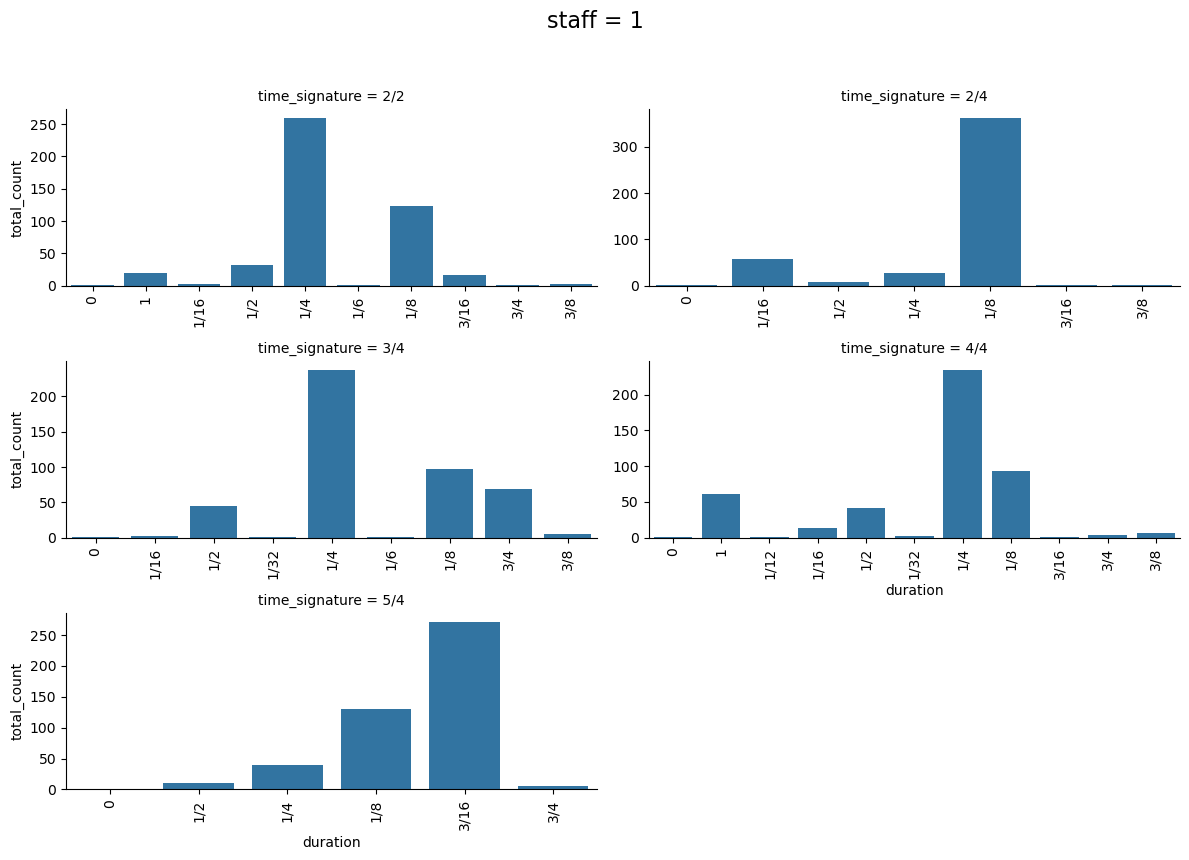

In [19]:
for staff in mc_onset_rest_count.staff.unique():
    g = sns.FacetGrid(data=mc_onset_rest_count[mc_onset_rest_count.staff==staff].groupby(by=['staff', 'time_signature', 'duration'], as_index=False).agg(total_count=('rest_count', 'sum')), col='time_signature', 
                      col_wrap=2, margin_titles=True, aspect = 2, sharex= False, sharey= False)

    #add histograms to each plot

    g.map(sns.barplot, 'duration', 'total_count')
    
    g.set_xticklabels(rotation=90)
    g.figure.subplots_adjust(top = 0.9)
    g.figure.suptitle(f"staff = {staff}", size = 16)

    g.figure.tight_layout(rect=[0, 0.03, 1, 0.95])   

### Estadísticas de las los rangos MIDI
El ejecutante del piano en el jazz típicamente tocará a 2 manos. Ls disposición de las mismas debe ser notoria en los pentagramas que las partituras describen. El siguiente análisis estadístico muestra la clara división de las notas que cada pentagrama describe. El pentagrama $2$ describe las notas más graves y esto indicaría su ejecución por la mano izquierda, mientras que el pentagrama $1$ describe las notas más agudas. Desde aquí se puede prescindir de los petagramas 3 y 4 para entrenar la red neuronal.

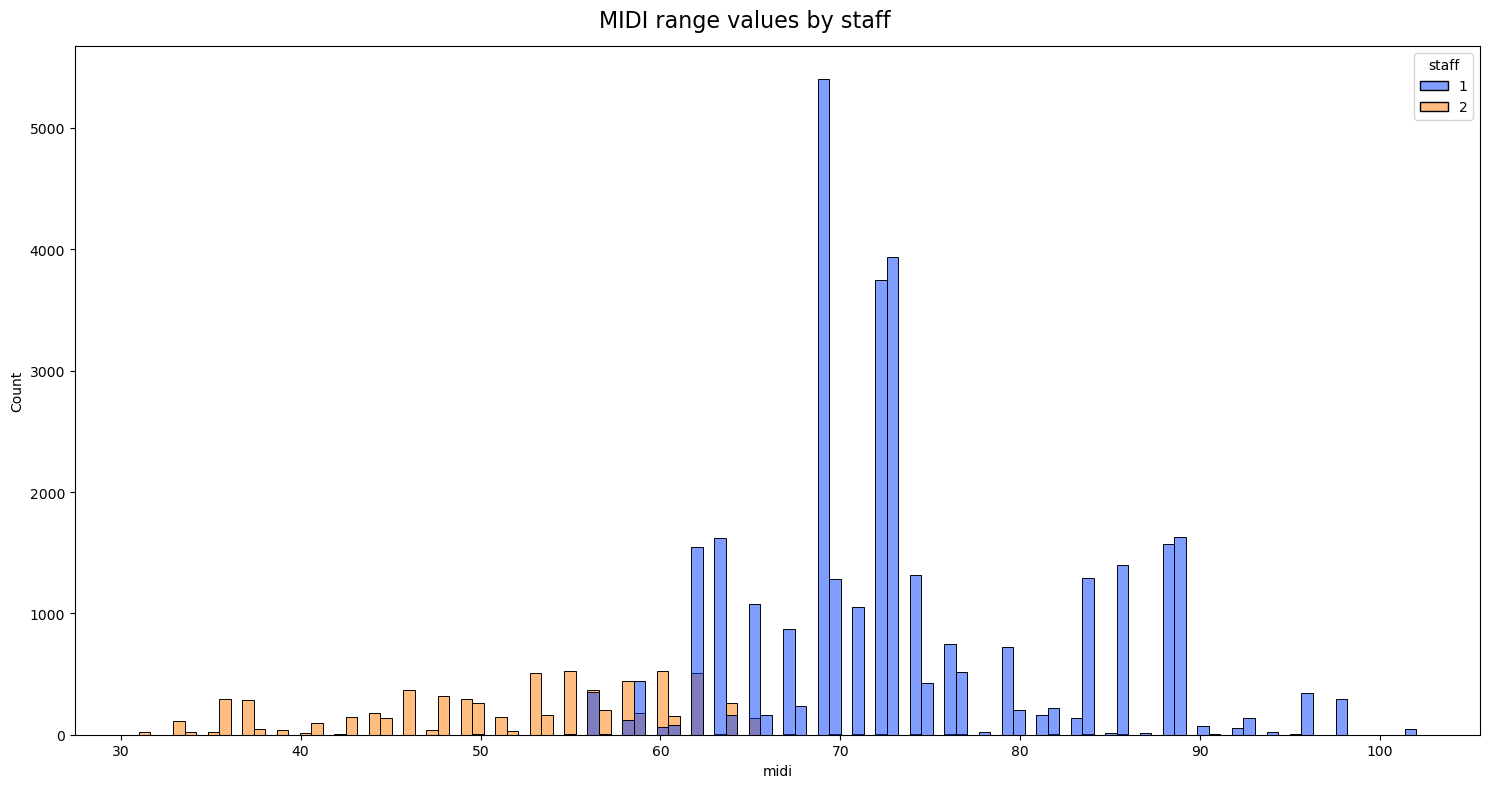

In [20]:
columnas = 1
renglones = 1

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(15, 8))
fig.suptitle("MIDI range values by staff", fontsize = 16)

##for staff in n_notes_midi_range.staff.unique():
    ##n_notes_midi_range_staff = n_notes_midi_range[n_notes_midi_range.staff == staff]
sns.histplot(data = n_notes_midi_range, palette='bright', ##multiple='stack', 
             x = 'midi', label = f"staff {staff}", hue = 'staff')

##fig.legend()  
fig.tight_layout()  

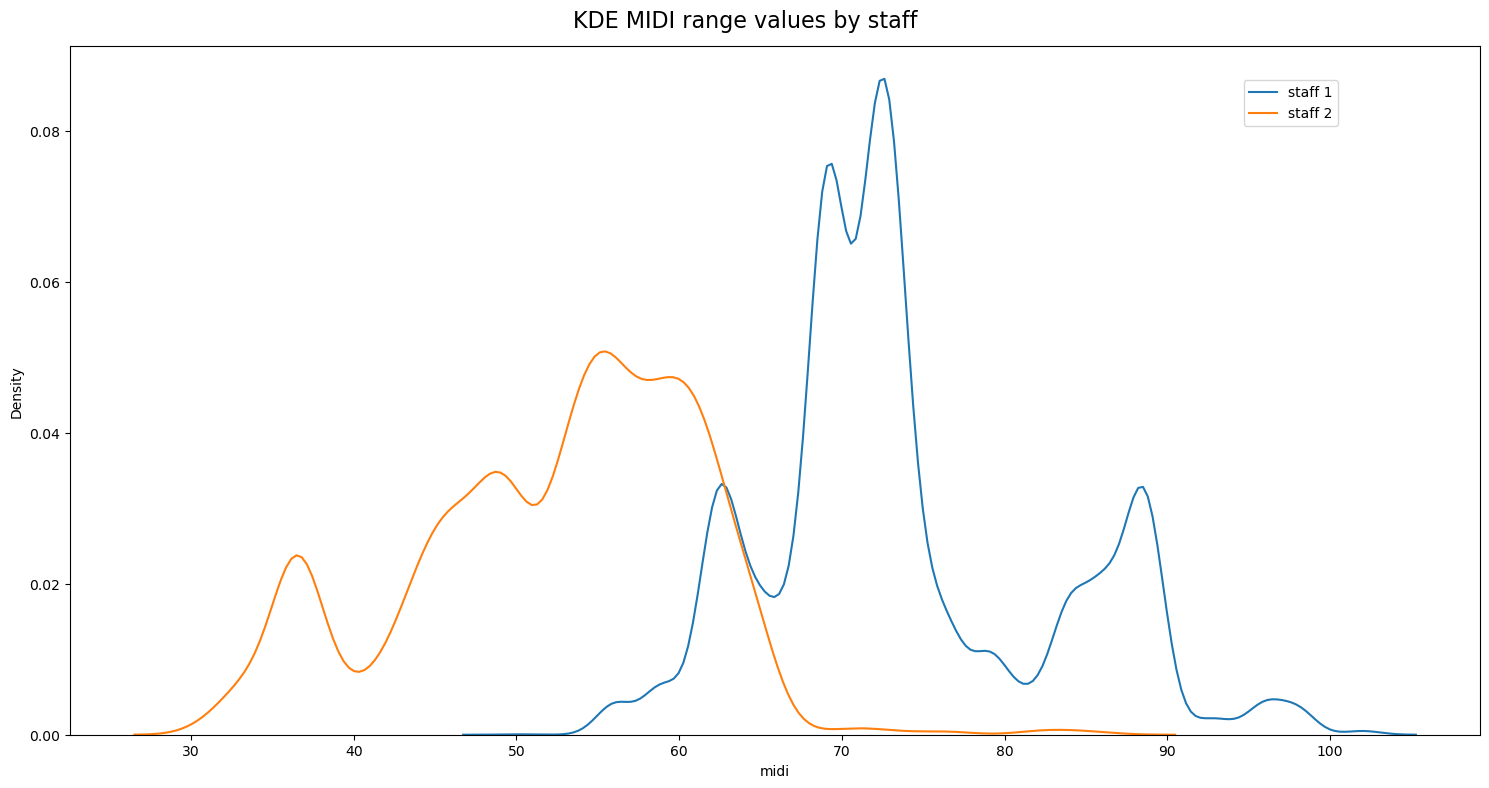

In [21]:
columnas = 1
renglones = 1

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(15, 8))
fig.suptitle("KDE MIDI range values by staff", fontsize = 16)

for staff in n_notes_midi_range.staff.unique():
    n_notes_midi_range_staff = n_notes_midi_range[n_notes_midi_range.staff == staff]
    sns.kdeplot(data = n_notes_midi_range_staff, 
             x = 'midi', label = f"staff {staff}")

fig.legend(bbox_to_anchor=(0.9, 0.9))  
fig.tight_layout()  

Se puede concluir que los tiempos llegan a representar la mitad de todas las rebanadas de $n$-notas, esto supone un problema al entrenamiento de la red, ya que muchos silencios seguidos han mostrado tener un impacto en enseñar a la red a entrar en la generación de silencios en secuencia de los cuales la red neuronal no es capaz de retomar la creación de nuevas $n$-notas.

In [22]:
new_n_notes_count = pd.read_csv('.\\comparisondata\\n_notes_count.csv', index_col = 0)
new_mc_onset_count = pd.read_csv('.\\comparisondata\\mc_onset_count.csv', index_col = 0)
new_mc_onset_rest_count = pd.read_csv('.\\comparisondata\\mc_onset_rest_count.csv', index_col = 0)
new_n_notes_midi_range = pd.read_csv('.\\comparisondata\\n_notes_midi_range.csv', index_col = 0)

old_n_notes_count = pd.read_csv('.\\data\\n_notes_count.csv', index_col = 0)
old_mc_onset_count = pd.read_csv('.\\data\\mc_onset_count.csv', index_col = 0)
old_mc_onset_rest_count = pd.read_csv('.\\data\\mc_onset_rest_count.csv', index_col = 0)
old_n_notes_midi_range = pd.read_csv('.\\data\\n_notes_midi_range.csv', index_col = 0)

In [23]:
import seaborn as sns
from scipy.stats import ks_2samp, chisquare, chi2_contingency, wasserstein_distance
from scipy.spatial import distance
import numpy as np
import pandas as pd

%matplotlib inline

In [24]:
time_signatures = ['2/2', '2/4', '4/4', '3/4', '5/4']
staves = [1, 2]

for time_signature in time_signatures:
    for staff in staves:
        new_count_n_notes = new_n_notes_count[(new_n_notes_count.staff==staff) &
                                              (new_n_notes_count.time_signature == time_signature)].count_n_notes
        old_count_n_notes = old_n_notes_count[(old_n_notes_count.staff==staff) & 
                                              (old_n_notes_count.time_signature == time_signature)].count_n_notes
        result = ks_2samp(new_count_n_notes, old_count_n_notes)
        print(f'staff = {staff}, time signature = {time_signature} \t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

staff = 1, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.4269
staff = 2, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.4164
staff = 2, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.2564
staff = 2, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.3010
staff = 2, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 5/4 	=> p_value = 0.0000, statistic = 0.4988
staff = 2, time signature = 5/4 	=> p_value = 0.0000, statistic = 0.8958


In [25]:
time_signatures = ['2/2', '2/4', '4/4', '3/4', '5/4']
staves = [1, 2]

##mc_onset_count[mc_onset_count.staff==staff].groupby(by=['staff', 'time_signature', 'duration'], as_index=False).agg(total_count=('n_note_count', 'sum'))

for time_signature in time_signatures:
    for staff in staves:
        durations = new_mc_onset_count[(new_mc_onset_count.staff==staff) &
                                              (new_mc_onset_count.time_signature == time_signature)]['duration'].unique()
        ##print(durations)
        new_mc_onset = new_mc_onset_count[(new_mc_onset_count.staff==staff) &
                                              (new_mc_onset_count.time_signature == time_signature)][['duration', 'n_note_count']]
        old_mc_onset = old_mc_onset_count[(old_mc_onset_count.staff==staff) & 
                                              (old_mc_onset_count.time_signature == time_signature) &
                                              (old_mc_onset_count.duration.isin(durations))][['duration', 'n_note_count']]
        
        new_mc_onset['duration_frac'] = new_mc_onset['duration'].map(Fraction)
        old_mc_onset['duration_frac'] = old_mc_onset['duration'].map(Fraction)
        
        new_mc_onset.index = new_mc_onset['duration_frac']
        old_mc_onset.index = old_mc_onset['duration_frac']
        
        result = ks_2samp(new_mc_onset.n_note_count, old_mc_onset.n_note_count)
        print(f'staff = {staff}, time signature = {time_signature} \t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

staff = 1, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.9162
staff = 2, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.9359
staff = 2, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.8658
staff = 2, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.8705
staff = 2, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.8958
staff = 1, time signature = 5/4 	=> p_value = 0.0000, statistic = 0.8771
staff = 2, time signature = 5/4 	=> p_value = 0.0000, statistic = 0.8958


In [26]:
time_signatures = ['2/2', '2/4', '4/4', '3/4', '5/4']
staves = [1, 2]

##mc_onset_count[mc_onset_count.staff==staff].groupby(by=['staff', 'time_signature', 'duration'], as_index=False).agg(total_count=('n_note_count', 'sum'))

for time_signature in time_signatures:
    for staff in staves:
        durations = new_mc_onset_rest_count[(new_mc_onset_rest_count.staff==staff) &
                                              (new_mc_onset_rest_count.time_signature == time_signature)]['duration'].unique()
        ##print(durations)
        new_mc_onset = new_mc_onset_rest_count[(new_mc_onset_rest_count.staff==staff) &
                                              (new_mc_onset_rest_count.time_signature == time_signature)][['duration', 'rest_count']]
        old_mc_onset = old_mc_onset_rest_count[(old_mc_onset_rest_count.staff==staff) & 
                                              (old_mc_onset_rest_count.time_signature == time_signature) &
                                              (old_mc_onset_rest_count.duration.isin(durations))][['duration', 'rest_count']]
        
        new_mc_onset['duration_frac'] = new_mc_onset['duration'].map(Fraction)
        old_mc_onset['duration_frac'] = old_mc_onset['duration'].map(Fraction)
        
        new_mc_onset.index = new_mc_onset['duration_frac']
        old_mc_onset.index = old_mc_onset['duration_frac']
        
        result = ks_2samp(new_mc_onset.rest_count, old_mc_onset.rest_count)
        print(f'staff = {staff}, time signature = {time_signature} \t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

staff = 1, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.8421
staff = 2, time signature = 2/2 	=> p_value = 0.0000, statistic = 0.8281
staff = 1, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.8225
staff = 2, time signature = 2/4 	=> p_value = 0.0000, statistic = 0.7859
staff = 1, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.8009
staff = 2, time signature = 4/4 	=> p_value = 0.0000, statistic = 0.7591
staff = 1, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.8857
staff = 2, time signature = 3/4 	=> p_value = 0.0000, statistic = 0.6286
staff = 1, time signature = 5/4 	=> p_value = 0.0000, statistic = 1.0000
staff = 2, time signature = 5/4 	=> p_value = 0.1621, statistic = 0.3750


In [27]:
staves = [1, 2]

##mc_onset_count[mc_onset_count.staff==staff].groupby(by=['staff', 'time_signature', 'duration'], as_index=False).agg(total_count=('n_note_count', 'sum'))

for staff in staves:
    midi_notes = new_n_notes_midi_range[(new_n_notes_midi_range.staff==staff)]['midi'].unique()
    ##print(durations)
    new_midi_notes = new_n_notes_midi_range[(new_n_notes_midi_range.staff==staff)]['midi']
    old_midi_notes = old_n_notes_midi_range[(old_n_notes_midi_range.staff==staff) &
                                          (old_n_notes_midi_range.midi.isin(midi_notes))]['midi']

    result = ks_2samp(new_midi_notes, old_midi_notes)
    print(f'staff = {staff}. \t=> p_value = {result.pvalue:.4f}, statistic = {result.statistic:.4f}')

staff = 1. 	=> p_value = 0.0000, statistic = 0.1299
staff = 2. 	=> p_value = 0.0000, statistic = 0.0607


## Comparación de las PMFs

In [28]:
staff01_4_4_1_notes_durations = pd.read_csv('.\\data\\staff01_4_4_1_notes_durations.csv', index_col = 0)
staff01_4_4_2_notes_durations = pd.read_csv('.\\data\\staff01_4_4_1_notes_durations.csv', index_col = 0)
staff01_4_4_3_notes_durations = pd.read_csv('.\\data\\staff01_4_4_1_notes_durations.csv', index_col = 0)
staff01_4_4_4_notes_durations = pd.read_csv('.\\data\\staff01_4_4_1_notes_durations.csv', index_col = 0)
staff01_4_4_5_notes_durations = pd.read_csv('.\\data\\staff01_4_4_1_notes_durations.csv', index_col = 0)

staff02_4_4_1_notes_durations = pd.read_csv('.\\data\\staff02_4_4_1_notes_durations.csv', index_col = 0)
staff02_4_4_2_notes_durations = pd.read_csv('.\\data\\staff02_4_4_1_notes_durations.csv', index_col = 0)
staff02_4_4_3_notes_durations = pd.read_csv('.\\data\\staff02_4_4_1_notes_durations.csv', index_col = 0)
staff02_4_4_4_notes_durations = pd.read_csv('.\\data\\staff02_4_4_1_notes_durations.csv', index_col = 0)
staff02_4_4_5_notes_durations = pd.read_csv('.\\data\\staff02_4_4_1_notes_durations.csv', index_col = 0)

In [29]:
staff01_1_notes_durations = staff01_4_4_1_notes_durations
staff01_2_notes_durations = staff01_4_4_2_notes_durations
staff01_3_notes_durations = staff01_4_4_3_notes_durations
staff01_4_notes_durations = staff01_4_4_4_notes_durations
staff01_5_notes_durations = staff01_4_4_5_notes_durations

staff02_1_notes_durations = staff02_4_4_1_notes_durations
staff02_2_notes_durations = staff02_4_4_2_notes_durations
staff02_3_notes_durations = staff02_4_4_3_notes_durations
staff02_4_notes_durations = staff02_4_4_4_notes_durations
staff02_5_notes_durations = staff02_4_4_5_notes_durations

<Axes: xlabel='duration', ylabel='distribution'>

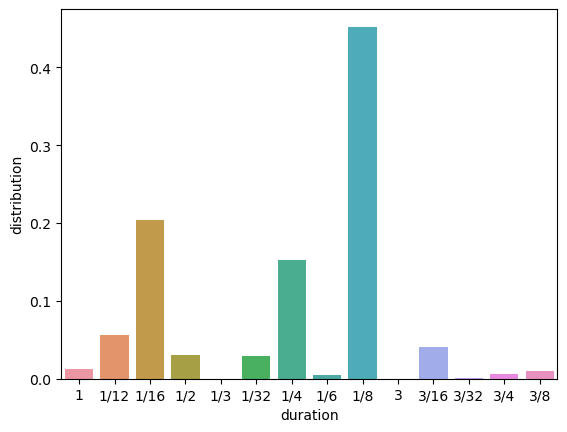

In [30]:
sns.barplot(staff01_1_notes_durations, x= 'duration', y='distribution')

<Axes: xlabel='duration', ylabel='distribution'>

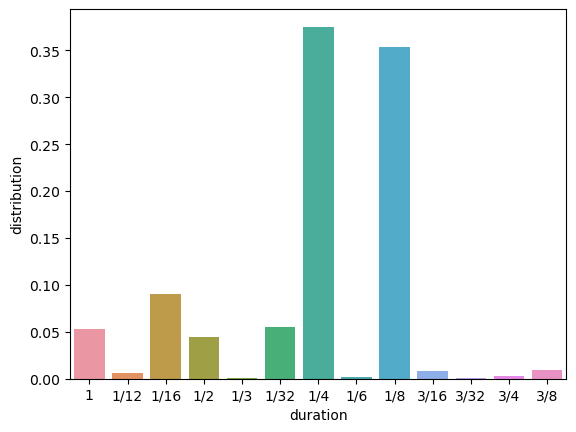

In [31]:
sns.barplot(staff02_1_notes_durations, x= 'duration', y='distribution')

C:\Users\ismedina\AppData\Local\Temp\ipykernel_6700\1202115366.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = staff01_3_notes_durations.append(staff02_3_notes_durations, ignore_index=True)


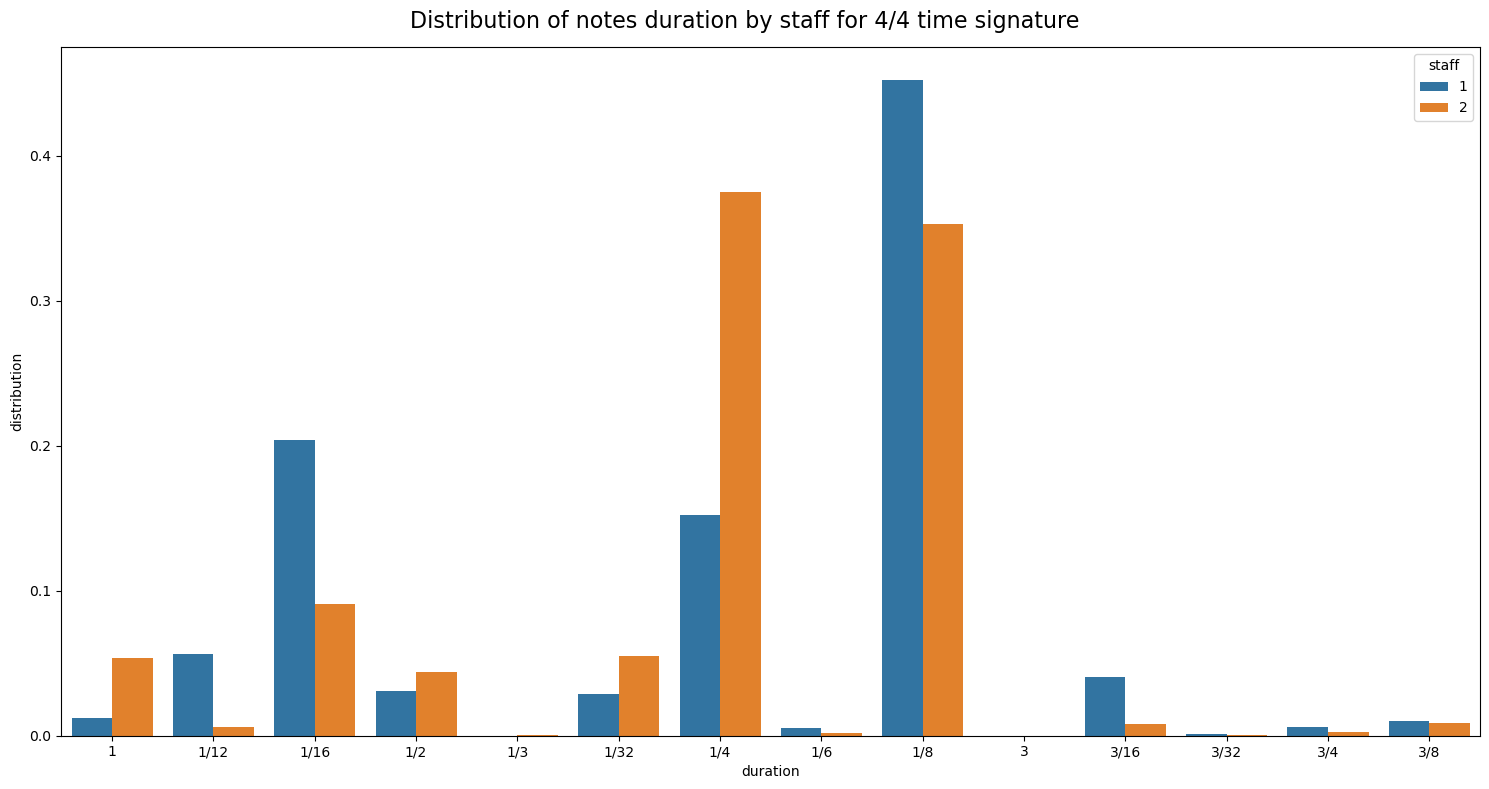

In [32]:
columnas = 1
renglones = 1
staff01_3_notes_durations['staff'] = 1
staff02_3_notes_durations['staff'] = 2
df = staff01_3_notes_durations.append(staff02_3_notes_durations, ignore_index=True)

fig, axes = plt.subplots(nrows = renglones, ncols = columnas, figsize=(15, 8))
fig.suptitle("Distribution of notes duration by staff for 4/4 time signature", fontsize = 16)

sns.barplot(df, x= 'duration', y='distribution', hue = 'staff')

fig.tight_layout()  



# Referencias

* Briot, J. (2021). From artificial neural networks to deep learning for music generation: history, concepts and trends. *Neural Comput & Applic 33*, 36-65.
* Ijas, A. H. (2 de Noviembre de 2019). *Build a simple predictive keyboard using python and Keras*. Obtenido de medium.com: https://medium.com/analytics-vidhya/build-a-simple-predictive-keyboard-using-python-and-keras-b78d3c88cffb
* Lozano Cruz, O. S.-G. (6 de Junio de 2013). El cerebro y la música. *Rev Med UV, Enero - Junio 2013*, págs. 17-22.
* Morán Martínez, M. C. (1 de Noviembre de 2009). Psicología y Música: inteligencia musical y desarrollo estético*. *Revista Digital Universitaria*, págs. 1-13.

